In [1]:
num_experiments = 10
observation_sizes = [100, 1000, 5000]
num_cv = 5

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import pdist
from Environment import AvgEnvironment
from Policy import MultinomialPolicy
from ParameterSelector import ParameterSelector
# from kernel import Exponential, Gaussian, Linear, Polynomial, RationalQuadratic
from Estimator_CPME import *

2025-05-18 15:21:05.259509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747581665.284760 2220831 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747581665.292805 2220831 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747581665.313040 2220831 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747581665.313063 2220831 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747581665.313066 2220831 computation_placer.cc:177] computation placer alr

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
config = {
    "n_users": 50,
    "n_items": 20,
    "context_dim": 10,
    "n_reco": 4,
}

obs_size = 100
num_iter = 5

In [4]:
# === Generate environment ===
user_vectors = np.random.normal(0, 1, size=(config["n_users"], config["context_dim"]))
target_user_vectors = user_vectors * np.random.binomial(1, 0.5, size=user_vectors.shape)
item_vectors = np.random.normal(0, 1, size=(config["n_items"], config["context_dim"]))

alpha = -0.3
logging_user_vectors = alpha * target_user_vectors

logging_policy = MultinomialPolicy(item_vectors, logging_user_vectors, config["n_items"], config["n_reco"], temperature=0.5, cal_gamma=True)
target_policy = MultinomialPolicy(item_vectors, target_user_vectors, config["n_items"], config["n_reco"], temperature=1.0, cal_gamma=False)
environment = AvgEnvironment(item_vectors, user_vectors)

seed = 0
np.random.seed(seed)

# === Generate simulation data ===
sim_data = []
for _ in range(obs_size):
    user = environment.get_context()

    logging_reco, logging_multinomial, logging_user_vector = logging_policy.recommend(user)
    target_reco, target_multinomial, _ = target_policy.recommend(user)

    sim_data.append({
        "null_context_vec": logging_user_vector,
        "target_context_vec": logging_user_vector,
        "null_reco": tuple(logging_reco),
        "null_reco_vec": np.concatenate(item_vectors[logging_reco]),
        "null_reward": environment.get_reward(user, logging_reco),
        "target_reco": tuple(target_reco),
        "target_multinomial": target_multinomial,
        "target_reco_vec": np.concatenate(item_vectors[target_reco]),
        "target_reward": environment.get_reward(user, target_reco),
        "null_multinomial": logging_multinomial,
        "user": user,
    })

sim_data = pd.DataFrame(sim_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


2025-05-18 15:22:42.550325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-18 15:22:42.550387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747581762.595386 2220932 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747581762.595395 2220933 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747581762.609283 2220932 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1747581762.609470 2220933 cuda_blas.cc:1

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   50.9s
[Paralle

In [13]:
direct_selector.estimator.params

(150, 1024, 100)

In [21]:
# === Calculate results ===
actual_value = np.mean(sim_data["target_reward"])

estimator_name = "DoublyRobustEstimator"

if estimator_name == "IPS":
    estimator = IPSEstimator(logging_policy, target_policy, null_propensity_known = True)
elif estimator_name == "DirectEstimator":
    estimator = DirectEstimator()
    # parameter selection
    direct_selector = ParameterSelector(estimator)  # direct estimator
    params_grid = [(n_hiddens, 1024, 100) for n_hiddens in [50, 100, 150, 200]]
    direct_selector.select_from_propensity(sim_data, params_grid, logging_policy, target_policy)
    estimator = direct_selector.estimator
elif estimator_name == "DoublyRobustEstimator":
    estimator = DoublyRobustEstimator(logging_policy, target_policy, null_propensity_known = True)
    try:
        estimator.params = direct_selector.parameters  # doubly robust estimator
    except:
        pass
elif estimator_name == "CMEbis":
    estimator = CMEbis(rbf_kernel, rbf_kernel, params=[5e-5, 1.0, 1.0])
    cme_selector = ParameterSelector(estimator)  # cme estimator
    params_grid = [[(10.0 ** p) / obs_size, 1.0, 1.0] for p in np.arange(-7, 0, 1)]
    cme_selector.select_from_propensity(sim_data, params_grid, logging_policy, target_policy)
    estimator = cme_selector.estimator
    
# === Prepare features for reward estimators ===
logging_context_vec = np.vstack(sim_data["null_context_vec"].dropna().values)
logging_reco_vec = np.vstack(sim_data["null_reco_vec"].dropna().values)
logging_reward = sim_data["null_reward"].dropna().values

X_logging = np.hstack([logging_context_vec, logging_reco_vec])
# === Train reward models where needed ===
if isinstance(estimator, DirectEstimator):
    estimator.fit(X_logging, logging_reward, n_hidden_units=estimator.params[0], batch_size=1024, epochs=100)
if isinstance(estimator, DoublyRobustEstimator):
    estimator.fit(X_logging, logging_reward)
est_value = estimator.estimate(sim_data)
mse = (est_value - actual_value) ** 2
print("MSE : {}".format(mse))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
MSE : 0.11067045920238174


In [22]:
target_multinomial

array([0.01332576, 0.02242309, 0.01262225, 0.01485058, 0.21154041,
       0.08473912, 0.07170478, 0.02784341, 0.1271621 , 0.01022998,
       0.01539362, 0.0496466 , 0.09894114, 0.02368   , 0.05547324,
       0.02933306, 0.0119512 , 0.06903711, 0.02392087, 0.02618167])

In [4]:
def simulate_observation_size(obs_size, config, num_iter):
    results = []

    # === Generate environment ===
    user_vectors = np.random.normal(0, 1, size=(config["n_users"], config["context_dim"]))
    target_user_vectors = user_vectors * np.random.binomial(1, 0.5, size=user_vectors.shape)
    item_vectors = np.random.normal(0, 1, size=(config["n_items"], config["context_dim"]))

    alpha = -0.3
    logging_user_vectors = alpha * target_user_vectors

    logging_policy = MultinomialPolicy(item_vectors, logging_user_vectors, config["n_items"], config["n_reco"], temperature=0.5, cal_gamma=True)
    target_policy = MultinomialPolicy(item_vectors, target_user_vectors, config["n_items"], config["n_reco"], temperature=1.0, cal_gamma=False)
    environment = AvgEnvironment(item_vectors, user_vectors)

    seeds = np.random.randint(np.iinfo(np.int32).max, size=num_iter)

    for seed in tqdm(seeds, desc=f"Obs size {obs_size}"):
        np.random.seed(seed)

        # === Generate simulation data ===
        sim_data = []
        for _ in range(obs_size):
            user = environment.get_context()

            logging_reco, logging_multinomial, logging_user_vector = logging_policy.recommend(user)
            target_reco, target_multinomial, _ = target_policy.recommend(user)

            sim_data.append({
                "null_context_vec": logging_user_vector,
                "target_context_vec": logging_user_vector,
                "null_reco": tuple(logging_reco),
                "null_reco_vec": np.concatenate(item_vectors[logging_reco]),
                "null_reward": environment.get_reward(user, logging_reco),
                "target_reco": tuple(target_reco),
                "target_multinomial": target_multinomial,
                "target_reco_vec": np.concatenate(item_vectors[target_reco]),
                "target_reward": environment.get_reward(user, target_reco),
                "null_multinomial": logging_multinomial,
                "user": user,
            })

        sim_data = pd.DataFrame(sim_data)

        # === Prepare estimators ===
        behavior_estimator = BehaviorPolicyEstimator(config["n_items"])
        user_features = np.vstack(sim_data["null_context_vec"].values)
        actions = [r[0] for r in sim_data["null_reco"].values]  # Taking first item as action

        behavior_estimator.fit(user_features, actions)

        estimators = [
            IPSEstimator(logging_policy, target_policy, null_propensity_known = True),
            DirectEstimator(),
            DoublyRobustEstimator(logging_policy, target_policy, null_propensity_known = True),
            # CMEstimator(rbf_kernel, rbf_kernel, params=[5e-5, 1.0, 1.0]),
            # DRCMEstimator(rbf_kernel, rbf_kernel, [1e-3, 1.0, 1.0], behavior_estimator, target_policy), 
            CMEbis(rbf_kernel, rbf_kernel, params=[5e-5, 1.0, 1.0]),
            DoublyRobustbis(rbf_kernel, rbf_kernel, [5e-5, 1.0, 1.0], logging_policy, target_policy, null_propensity_known = True)
        ]

        # parameter selection
        direct_selector = ParameterSelector(estimators[2])  # direct estimator
        params_grid = [(n_hiddens, 1024, 100) for n_hiddens in [50, 100, 150, 200]]
        direct_selector.select_from_propensity(sim_data, params_grid, logging_policy, target_policy)
        estimators[2] = direct_selector.estimator
        
        estimators[3].params = direct_selector.parameters  # doubly robust estimator
        
        cme_selector = ParameterSelector(estimators[4])  # cme estimator
        params_grid = [[(10.0 ** p) / config['n_observation'], 1.0, 1.0] for p in np.arange(-7, 0, 1)]
        cme_selector.select_from_propensity(sim_data, params_grid, logging_policy, target_policy)
        estimators[4] = cme_selector.estimator
        
        estimators[5].params = estimators[4]._params
        # === Prepare features for reward estimators ===
        logging_context_vec = np.vstack(sim_data["null_context_vec"].dropna().values)
        logging_reco_vec = np.vstack(sim_data["null_reco_vec"].dropna().values)
        logging_reward = sim_data["null_reward"].dropna().values

        X_logging = np.hstack([logging_context_vec, logging_reco_vec])

        # === Train reward models where needed ===
        for estimator in estimators:
            if isinstance(estimator, DirectEstimator):
                estimator.fit(X_logging, logging_reward, n_hidden_units=estimator.params[0], batch_size=1024, epochs=100)
            if isinstance(estimator, DoublyRobustEstimator):
                estimator.fit(X_logging, logging_reward)

        # === Calculate results ===
        actual_value = np.mean(sim_data["target_reward"])

        for estimator in estimators:
            est_value = estimator.estimate(sim_data)
            mse = (est_value - actual_value) ** 2
            results.append({
                "Estimator": estimator.name,
                "MSE": mse,
                "Observation Size": obs_size
            })

    return pd.DataFrame(results)


In [5]:

# Running the simulation
full_results = pd.concat(
    [simulate_observation_size(n, config, num_iter) for n in observation_sizes]
)

# Plotting results
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=full_results, x="Observation Size", y="MSE", hue="Estimator", marker="o"
)
plt.yscale("log")
plt.title("Number of Observations vs MSE")
plt.tight_layout()
plt.show()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


2025-05-18 15:14:54.924123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-18 15:14:54.924129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747581294.957801 2219450 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747581294.957800 2219451 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747581294.968246 2219451 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1747581294.968274 2219450 cuda_blas.cc:1

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   47.5s
[Paralle

Obs size 100:   0%|          | 0/5 [00:00<?, ?it/s]/nfs/ghome/live/bbozkurt/.conda/envs/tensorenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
I0000 00:00:1747581423.089868 2219423 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3105 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:84:00.0, compute capability: 8.6
I0000 00:00:1747581425.200368 2219634 service.cc:152] XLA service 0x7e179c005e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747581425.200393 2219634 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
2025-05-18 15:17:05.220559: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling ML

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


Obs size 100:   0%|          | 0/5 [00:08<?, ?it/s]


AttributeError: 'float' object has no attribute 'sum'

In [ ]:
# Plotting results
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=full_results[(full_results.Estimator != 'dr_cme_estimator')], x="Observation Size", y="MSE", hue="Estimator", marker="o"
)
plt.yscale("log")
plt.title("Number of Observations vs MSE")
plt.tight_layout()
plt.show()

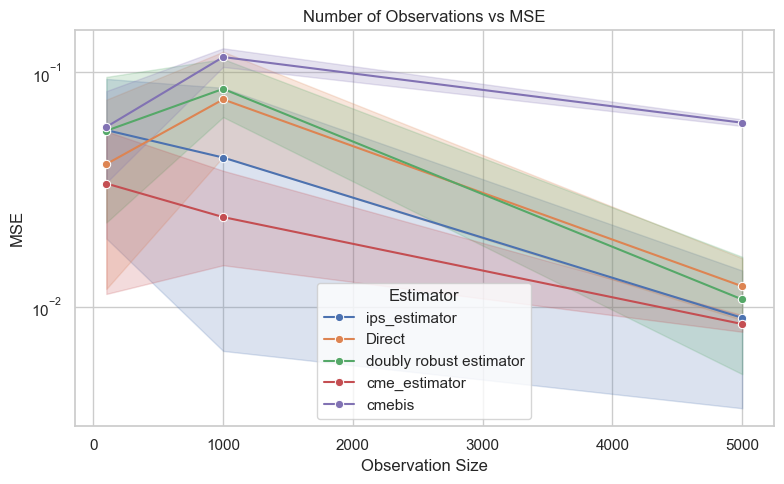

In [125]:
# Plotting results
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=full_results[(full_results.Estimator != 'dr_cme_estimator') & (full_results.Estimator != 'dr_bis')], x="Observation Size", y="MSE", hue="Estimator", marker="o"
)
plt.yscale("log")
plt.title("Number of Observations vs MSE")
plt.tight_layout()
plt.show()

In [128]:
full_results[(full_results.Estimator == 'cmebis') | (full_results.Estimator == 'dr_bis')]

,Estimator,MSE,Observation Size
5,cmebis,0.029216,100
6,dr_bis,0.029213,100
12,cmebis,0.081722,100
13,dr_bis,0.081724,100
19,cmebis,0.059683,100
20,dr_bis,0.059680,100
26,cmebis,0.025558,100
27,dr_bis,0.025558,100
33,cmebis,0.096179,100
34,dr_bis,0.096178,100


In [65]:
import jax.numpy as jnp
import numpy as np

from kernel import Exponential, Gaussian, Linear, Polynomial, RationalQuadratic

settings = {"reg_lambda": 1e-5, "bandwidth": 1}


def _get_kernel(settings):
    if settings["kernel"] == "gauss":
        kernel = Gaussian(settings)
        return kernel
    elif settings["kernel"] == "exp":
        kernel = Exponential(settings)
        return kernel
    elif settings["kernel"] == "linear":
        return Linear(settings)
    elif settings["kernel"] == "polynomial":
        return Polynomial(settings)
    elif settings["kernel"] == "rq":
        return RationalQuadratic(settings)
    else:
        raise NotImplementedError

# === Generate simulation data ===
user_vectors = np.random.normal(0, 1, size=(config["n_users"], config["context_dim"]))
target_user_vectors = user_vectors * np.random.binomial(1, 0.5, size=user_vectors.shape)
item_vectors = np.random.normal(0, 1, size=(config["n_items"], config["context_dim"]))

alpha = -0.3
logging_user_vectors = alpha * target_user_vectors

logging_policy = MultinomialPolicy(item_vectors, logging_user_vectors, config["n_items"], config["n_reco"], temperature=0.5, cal_gamma=True)
target_policy = MultinomialPolicy(item_vectors, target_user_vectors, config["n_items"], config["n_reco"], temperature=1.0, cal_gamma=False)
environment = AvgEnvironment(item_vectors, user_vectors)

sim_data = []
for _ in range(obs_size):
        user = environment.get_context()

        logging_reco, logging_multinomial, logging_user_vector = logging_policy.recommend(user)
        target_reco, target_multinomial, _ = target_policy.recommend(user)

        sim_data.append({
        "logging_context_vec": logging_user_vector,
        "target_context_vec": logging_user_vector,
        "logging_reco": tuple(logging_reco),
        "logging_reco_vec": np.concatenate(item_vectors[logging_reco]),
        "logging_reward": environment.get_reward(user, logging_reco),
        "target_reco": tuple(target_reco),
        "target_multinomial": target_multinomial,
        "target_reco_vec": np.concatenate(item_vectors[target_reco]),
        "target_reward": environment.get_reward(user, target_reco),
        "logging_multinomial": logging_multinomial,
        "user": user,
        })

sim_data = pd.DataFrame(sim_data)





[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    6.6s remaining:   26.3s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    6.7s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    6.8s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.9s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    6.9s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.0s finished


In [66]:
sim_data

,logging_context_vec,target_context_vec,logging_reco,logging_reco_vec,logging_reward,target_reco,target_multinomial,target_reco_vec,target_reward,logging_multinomial,user
0,"[0.0, -0.0, -0.0, -0.0, 0.0]","[0.0, -0.0, -0.0, -0.0, 0.0]","(1, 8, 9, 12)","[-0.4358349834913552, 1.0254555700768233, -0.0...",0,"(14, 4, 1, 10)","[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","[-0.9256260367226805, -0.007830870008659103, 0...",1,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...",3
1,"[0.21360987207871576, -0.10427410231936293, -0...","[0.21360987207871576, -0.10427410231936293, -0...","(12, 10, 7, 0)","[-0.19738179424941676, 1.671202072272812, 0.52...",0,"(10, 14, 18, 4)","[0.01928113420032203, 0.044598081638489266, 0....","[-1.1302463306404904, 1.792649223582581, 1.797...",1,"[0.05113150968816029, 0.04508801081519802, 0.0...",4
2,"[0.4198860787048842, -0.6548985850854564, 0.0,...","[0.4198860787048842, -0.6548985850854564, 0.0,...","(18, 12, 9, 14)","[0.8033827292065501, -0.8485841276216847, -1.3...",1,"(12, 1, 10, 3)","[0.006937848492731827, 0.0874633618800129, 3.9...","[-0.19738179424941676, 1.671202072272812, 0.52...",1,"[0.03087421454560486, 0.02111084973576335, 0.0...",6
3,"[0.7336180622814856, -0.0, 0.13477225277999974...","[0.7336180622814856, -0.0, 0.13477225277999974...","(15, 18, 8, 10)","[1.2453069458345865, -1.808832351576569, -0.41...",0,"(6, 14, 4, 19)","[0.0010365064283952786, 0.012724991417509159, ...","[-0.08561691521998496, -2.432704795533552, 1.1...",1,"[0.059601532697458603, 0.040916135046917206, 0...",2
4,"[0.0, -0.0, 0.0, 0.13965533269395988, -0.0]","[0.0, -0.0, 0.0, 0.13965533269395988, -0.0]","(9, 0, 1, 5)","[0.3243135942096038, -0.534208083105601, -2.02...",1,"(19, 1, 13, 17)","[0.08479518194694054, 0.05058248771086369, 0.0...","[-1.1321545545378595, 0.13894021470071974, -0....",0,"[0.045648771948166175, 0.04932700502439304, 0....",9
...,...,...,...,...,...,...,...,...,...,...,...
95,"[0.4198860787048842, -0.6548985850854564, 0.0,...","[0.4198860787048842, -0.6548985850854564, 0.0,...","(10, 4, 6, 8)","[-1.1302463306404904, 1.792649223582581, 1.797...",0,"(3, 10, 12, 1)","[0.006937848492731827, 0.0874633618800129, 3.9...","[0.971091487237171, 0.9379053443315658, 0.1426...",1,"[0.03087421454560486, 0.02111084973576335, 0.0...",6
96,"[0.0, -0.0, 0.0, 0.13965533269395988, -0.0]","[0.0, -0.0, 0.0, 0.13965533269395988, -0.0]","(9, 8, 15, 0)","[0.3243135942096038, -0.534208083105601, -2.02...",0,"(5, 4, 0, 11)","[0.08479518194694054, 0.05058248771086369, 0.0...","[0.20389014208127826, 0.19229645713387436, -1....",1,"[0.045648771948166175, 0.04932700502439304, 0....",9
97,"[0.0, -0.0, -0.0, -0.0, 0.0]","[0.0, -0.0, -0.0, -0.0, 0.0]","(13, 8, 19, 10)","[0.45511007858513264, -0.8853124209955955, -0....",1,"(7, 4, 16, 5)","[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","[0.3128786364001493, -0.15667751206607267, -0....",0,"[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...",3
98,"[-0.0, 0.0, -0.05033205125250053, 0.0091219448...","[-0.0, 0.0, -0.05033205125250053, 0.0091219448...","(1, 18, 17, 13)","[-0.4358349834913552, 1.0254555700768233, -0.0...",1,"(8, 2, 10, 14)","[0.02600608757556106, 0.01146934361427036, 0.1...","[0.9342944225892453, -1.2239703760632892, -0.3...",1,"[0.04961203257006456, 0.05609413929572372, 0.0...",5


In [91]:
logging_context_vec = np.stack(
    sim_data["logging_context_vec"].dropna(axis=0).to_numpy()
)
logging_reco_vec = np.stack(
    sim_data["logging_reco_vec"].dropna(axis=0).to_numpy()
)
target_context_vec = np.stack(
    sim_data["target_context_vec"].dropna(axis=0).to_numpy()
)
target_reco_vec = np.stack(
    sim_data["target_reco_vec"].dropna(axis=0).to_numpy()
)
logging_reward = sim_data["logging_reward"].dropna(axis=0).values

target_reward = sim_data["target_reward"].dropna(axis=0).values

In [69]:
logging_context_vec.shape

(100, 5)

In [82]:
settings = {
    'reg_lambda': 0.1,
    'reg_lambda_tilde':0.01,
    'kernel': 'gauss',
    'bandwidth': 0.1,
}
reg_lambda = settings["reg_lambda"]
reg_lambda_1 = settings["reg_lambda_tilde"]

kernel_treatment = _get_kernel(settings)
kernel_covariates = _get_kernel(settings)

kernel_treatment.fit(logging_reco_vec)
kernel_covariates.fit(logging_context_vec)

K_T = kernel_treatment.gram_matrix(logging_reco_vec)
K_X = kernel_covariates.gram_matrix(logging_context_vec)

K_T_tilde = kernel_treatment.evaluate(logging_reco_vec, target_reco_vec)
K_X_tilde = kernel_covariates.evaluate(logging_context_vec, target_context_vec)

n = logging_context_vec.shape[0]
A_logging = np.multiply(K_X, K_T) + n * reg_lambda * np.eye(n)
b_logging = np.multiply(K_T_tilde, K_X_tilde)
inv_K_tilde_K =  np.linalg.solve(A_logging, b_logging)
np.mean(np.dot(logging_reward,inv_K_tilde_K))

In [85]:
K_T.shape, K_X.shape, K_T_tilde.shape, K_X_tilde.shape

((100, 100), (100, 100), (100, 100), (100, 100))

68.99219088443058

In [93]:
np.mean(logging_reward)

0.49

In [94]:
np.mean(target_reward)

0.67

In [ ]:



K_T_M_X = K_T * K_M * K_X + n * reg_lambda * jnp.eye(n)
K_T_X = K_T * K_X + n * reg_lambda_1 * jnp.eye(n)

def _kme_cross_conditional_mean_outcomes(d, d_prime, y, a, x):
    """
    Estimate the cross conditional mean outcome

    Parameters
    ----------
    y       array-like, shape (n_samples)
            outcome value for each unit, continuous

    t       array-like, shape (n_samples)
            treatment value for each unit, binary

    m       array-like, shape (n_samples)
            mediator value for each unit, here m is necessary binary and uni-
            dimensional

    x       array-like, shape (n_samples, n_features_covariates)
            covariates (potential confounders) values

    settings dictionary
            parameters for the kernel

    Returns
    -------
    mu_0m : array-like, shape (n_samples)
            conditional mean outcome for control group

    mu_1m : array-like, shape (n_samples)
            conditional mean outcome for treatment group

    psi_t0t0 : array-like, shape (n_samples)
            cross conditional mean outcome

    psi_t0t1 : array-like, shape (n_samples)
            cross conditional mean outcome

    psi_t1t0 : array-like, shape (n_samples)
            cross conditional mean outcome

    psi_t1t1 : array-like, shape (n_samples)
            cross conditional mean outcome
    """
    n = x.shape[0]

    reg_lambda = settings["reg_lambda"]
    reg_lambda_1 = settings["reg_lambda_tilde"]

    kernel_treatment = _get_kernel(settings)
    kernel_mediator = _get_kernel(settings)
    kernel_covariates = _get_kernel(settings)

    kernel_treatment.fit(t)
    kernel_mediator.fit(m)
    kernel_covariates.fit(x)

    K_T = kernel_treatment.gram_matrix(t)
    K_M = kernel_mediator.gram_matrix(m)
    K_X = kernel_covariates.gram_matrix(x)

    K_T_M_X = K_T * K_M * K_X + n * reg_lambda * jnp.eye(n)
    K_T_X = K_T * K_X + n * reg_lambda_1 * jnp.eye(n)

    inv_K_T_M_X = np.linalg.inv(K_T_M_X)
    inv_K_T_X = np.linalg.inv(K_T_X)

    K_M_inv_K_T_X = np.dot(K_M, inv_K_T_X)
    Y_inv_K_T_M_X = np.dot(y, inv_K_T_M_X)

    d = d * np.array([1])
    d_prime = d_prime * np.array([1])

    K_Td = kernel_treatment.evaluate(t, d)
    K_Td_prime = kernel_treatment.evaluate(t, d_prime)

    #
    half_d = np.dot(K_M_inv_K_T_X, K_Td * K_X) * K_X
    half_d_prime = np.dot(K_M_inv_K_T_X, K_Td_prime * K_X) * K_X

    # eta_tt
    psi_d_d = np.dot(Y_inv_K_T_M_X, K_Td * half_d)

    # eta_td
    psi_d_d_prime = np.dot(Y_inv_K_T_M_X, K_Td_prime * half_d)

    # eta_dt
    psi_d_prime_d = np.dot(Y_inv_K_T_M_X, K_Td * half_d_prime)

    # eta_dd
    psi_d_prime_d_prime = np.dot(Y_inv_K_T_M_X, K_Td_prime * half_d_prime)

    mu_d = np.dot(Y_inv_K_T_M_X, K_Td * K_M * K_X)
    mu_d_prime = np.dot(Y_inv_K_T_M_X, K_Td_prime * K_M * K_X)

    return mu_d, mu_d_prime, psi_d_d, psi_d_d_prime, psi_d_prime_d, psi_d_prime_d_prime


def _kme_conditional_mean_outcome(d, d_prime, y, t, m, x, settings):
    """
    Estimate the mediated response curve

    Parameters
    ----------
    y       array-like, shape (n_samples)
            outcome value for each unit, continuous

    t       array-like, shape (n_samples)
            treatment value for each unit, binary

    m       array-like, shape (n_samples)
            mediator value for each unit, here m is necessary binary and uni-
            dimensional

    x       array-like, shape (n_samples, n_features_covariates)
            covariates (potential confounders) values

    settings dictionary
            parameters for the kernel

    Returns
    -------
    eta_t0t0 : array-like, shape (n_samples)
            mediated response curve

    eta_t0t1 : array-like, shape (n_samples)
            mediated response curve

    eta_t1t0 : array-like, shape (n_samples)
            mediated response curve

    eta_t1t1 : array-like, shape (n_samples)
            mediated response curve
    """
    _, _, psi_d_d, psi_d_d_prime, psi_d_prime_d, psi_d_prime_d_prime = (
        _kme_cross_conditional_mean_outcomes(d, d_prime, y, t, m, x, settings)
    )

    # eta_t1t1
    eta_d_d = np.mean(psi_d_d)

    # eta_t1t0
    eta_d_d_prime = np.mean(psi_d_d_prime)

    # eta_t0t1
    eta_d_prime_d = np.mean(psi_d_prime_d)

    # eta_t0t0
    eta_d_prime_d_prime = np.mean(psi_d_prime_d_prime)

    return eta_d_d, eta_d_d_prime, eta_d_prime_d, eta_d_prime_d_prime